<a href="https://colab.research.google.com/github/ehas1/Statistical-Bias-in-ML/blob/main/LIME_vs_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import shap
shap.initjs()
! pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=35377cc10c3193df11e21565e1658865ad40fcdede451743c407912520e8f850
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
df_filtered = pd.read_csv('cox-violent-parsed_filt.csv')
df_filtered

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1.0,Low,14/08/2013,Risk of Violence,1.0,Low,0.0,0.0
1,2,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1.0,Low,14/08/2013,Risk of Violence,1.0,Low,0.0,0.0
2,3,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,...,NaN,Risk of Recidivism,5.0,Medium,31/12/2014,Risk of Violence,2.0,Low,0.0,0.0
3,4,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3.0,Low,27/01/2013,Risk of Violence,1.0,Low,0.0,1.0
4,5,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4.0,Low,14/04/2013,Risk of Violence,3.0,Low,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8249,8250,manuel camposeco-mendez,manuel,camposeco-mendez,Male,03/02/1985,31,25 - 45,Hispanic,0,...,NaN,Risk of Recidivism,2.0,Low,25/07/2013,Risk of Violence,1.0,Low,1.0,0.0
8250,8251,jovan gonzalez-gomez,jovan,gonzalez-gomez,Male,28/09/1995,20,Less than 25,Caucasian,0,...,NaN,Risk of Recidivism,5.0,Medium,23/04/2014,Risk of Violence,5.0,Medium,0.0,0.0
8251,8252,lemy williams,lemy,williams,Male,23/09/1975,40,25 - 45,African-American,0,...,NaN,Risk of Recidivism,8.0,High,01/04/2014,Risk of Violence,5.0,Medium,3.0,0.0
8252,8253,lemy williams,lemy,williams,Male,23/09/1975,40,25 - 45,African-American,0,...,NaN,Risk of Recidivism,8.0,High,01/04/2014,Risk of Violence,5.0,Medium,3.0,0.0


# LIME vs. SHAP

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost.callback import TrainingCallback
import json
from graphviz import Digraph
from IPython.display import display
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# Load and preprocess data
print("\nLoading and preprocessing data...")
data = pd.read_csv('cox-violent-parsed_filt.csv')

# Remove cases where is_recid is -1 (unknown/pending)
data = data[data['is_recid'] != -1].copy()

# Select specific features
X = data[["sex", 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
          'priors_count', 'c_charge_degree']]
y = data['is_recid']

# Store original value ranges for denormalization
value_ranges = {}
for col in ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']:
    value_ranges[col] = {
        'min': float(X[col].min()),
        'max': float(X[col].max())
    }

# Save value ranges for visualization
with open('value_ranges.json', 'w') as f:
    json.dump(value_ranges, f)

# Fill missing values
X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')

def categorize_charge_degree(x):
    if pd.isna(x) or x == 'Unknown':
        return 'Other'
    if str(x).startswith('F'):
        return 'Felony'
    if str(x).startswith('M'):
        return 'Misdemeanor'
    return 'Other'

X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)

# Define categorical and numerical features
categorical_features = ['sex', 'race', 'c_charge_degree']
numerical_features = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']

# One-hot encode categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features)

# Clean up feature names
X_encoded.columns = [col.replace('[', '_').replace(']', '_').replace('<', '_').replace('>', '_')
                    for col in X_encoded.columns]

# Normalize numerical features
#for col in numerical_features:
#    if col in X_encoded.columns:
#        min_val = X_encoded[col].min()
#        max_val = X_encoded[col].max()
#        if max_val > min_val:
#            X_encoded[col] = (X_encoded[col] - min_val) / (max_val - min_val)


"""AS 6/30/2025: 1. Moved normalization to after train-test split to avoid data
leakage. 2. Replaced min-max range scaling with mean-std scaling to avoid sensi-
tivity to outliers."""

# Split the data
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and fit scaler on training data only
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_unscaled)

# Transform test data using the same scaler (without refitting)
X_test = scaler.transform(X_test_unscaled)

# Train model with better parameters
# AS: Eric, can you explain to me what each of these parameter does?
print("\nTraining XGBoost model...")
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'error', 'auc'],
    'eta': 0.05,  # Lower learning rate
    'max_depth': 5,
    'min_child_weight': 2,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,  # Balance positive and negative weights
    'base_score': np.mean(y_train),  # Set base score to mean of target
    'tree_method': 'hist'
}

# Create DMatrix objects
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=X_encoded.columns.tolist())
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=X_encoded.columns.tolist())
evallist = [(dtrain, 'train'), (dtest, 'eval')]

# Dictionary to store evaluation results
evaluation_results = {'train': {'error': [], 'auc': [], 'logloss': []},
                     'eval': {'error': [], 'auc': [], 'logloss': []}}

# AS: What does this class do? Why does the function always return False?
class MetricHistory(TrainingCallback):
    def after_iteration(self, model, epoch, evals_log):
        for data_name, metric_dict in evals_log.items():
            for metric_name, metric_values in metric_dict.items():
                evaluation_results[data_name][metric_name].append(metric_values[-1])
        return False

# Train the model
model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,  # Reduced number of rounds
    early_stopping_rounds=50,  # Add early stopping
    evals=evallist,
    verbose_eval=100,
    callbacks=[MetricHistory()]
)

# Save the model
model.save_model('xgboost_model.json')

# Make predictions
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = (y_pred == y_test).mean()


print(f"\nModel Accuracy: {accuracy:.4f}")


# Print prediction distribution
print("\nPrediction Distribution:")
print(f"Min probability: {y_pred_prob.min():.4f}")
print(f"Max probability: {y_pred_prob.max():.4f}")
print(f"Mean probability: {y_pred_prob.mean():.4f}")
print(f"Std probability: {y_pred_prob.std():.4f}")

# Get feature importance scores
importance_type = 'gain' # AS: How is 'gain' calculated?
scores = model.get_score(importance_type=importance_type)
feature_importance = pd.DataFrame({
    'feature': list(scores.keys()),
    'importance': list(scores.values())
}).sort_values('importance', ascending=False)

print("\nFeature Importance Scores:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.1f}")

# Save feature importance to CSV
feature_importance.to_csv('feature_importance.csv', index=False)


Loading and preprocessing data...


/tmp/ipython-input-3-1505869495.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].fillna('Unknown')
/tmp/ipython-input-3-1505869495.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['c_charge_degree'] = X['c_charge_degree'].apply(categorize_charge_degree)



Training XGBoost model...
[0]	train-logloss:0.68916	train-error:0.47935	train-auc:0.63924	eval-logloss:0.68954	eval-error:0.48800	eval-auc:0.65158
[100]	train-logloss:0.59679	train-error:0.32402	train-auc:0.74331	eval-logloss:0.60045	eval-error:0.31943	eval-auc:0.74129
[200]	train-logloss:0.58520	train-error:0.31280	train-auc:0.75571	eval-logloss:0.59450	eval-error:0.31543	eval-auc:0.74714
[300]	train-logloss:0.57577	train-error:0.30252	train-auc:0.76602	eval-logloss:0.59006	eval-error:0.31457	eval-auc:0.75156
[400]	train-logloss:0.56763	train-error:0.29680	train-auc:0.77439	eval-logloss:0.58726	eval-error:0.30971	eval-auc:0.75464
[499]	train-logloss:0.56097	train-error:0.29158	train-auc:0.78122	eval-logloss:0.58450	eval-error:0.30914	eval-auc:0.75761

Model Accuracy: 0.6909

Prediction Distribution:
Min probability: 0.0248
Max probability: 0.9849
Mean probability: 0.4736
Std probability: 0.2088

Feature Importance Scores:
priors_count: 5.2
age: 3.7
sex_Female: 3.1
race_African-Americ

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


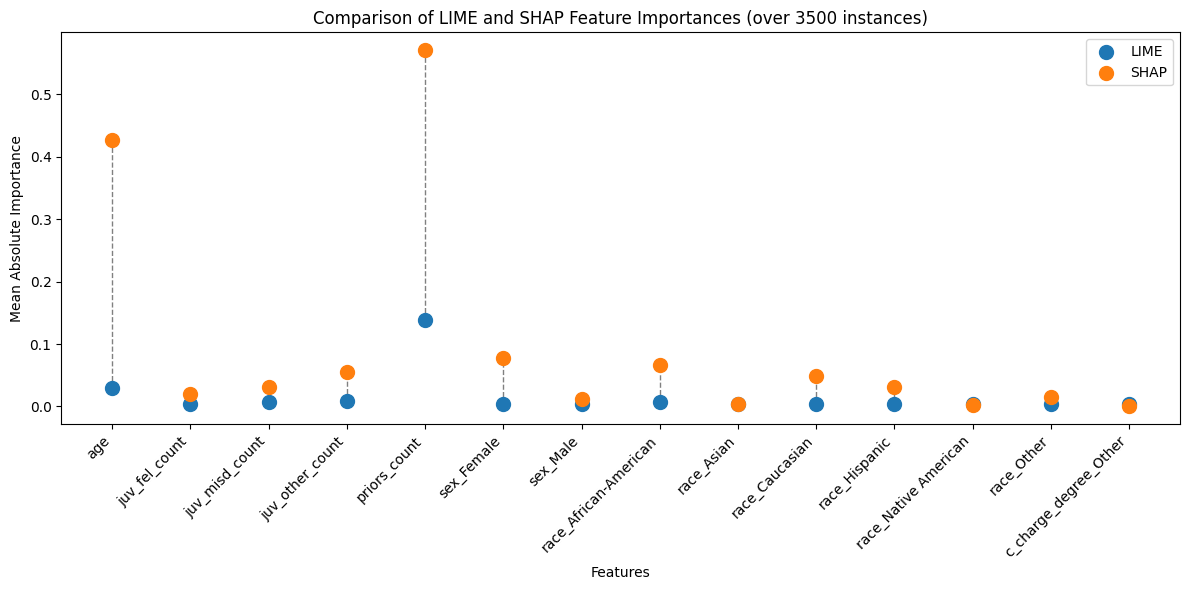

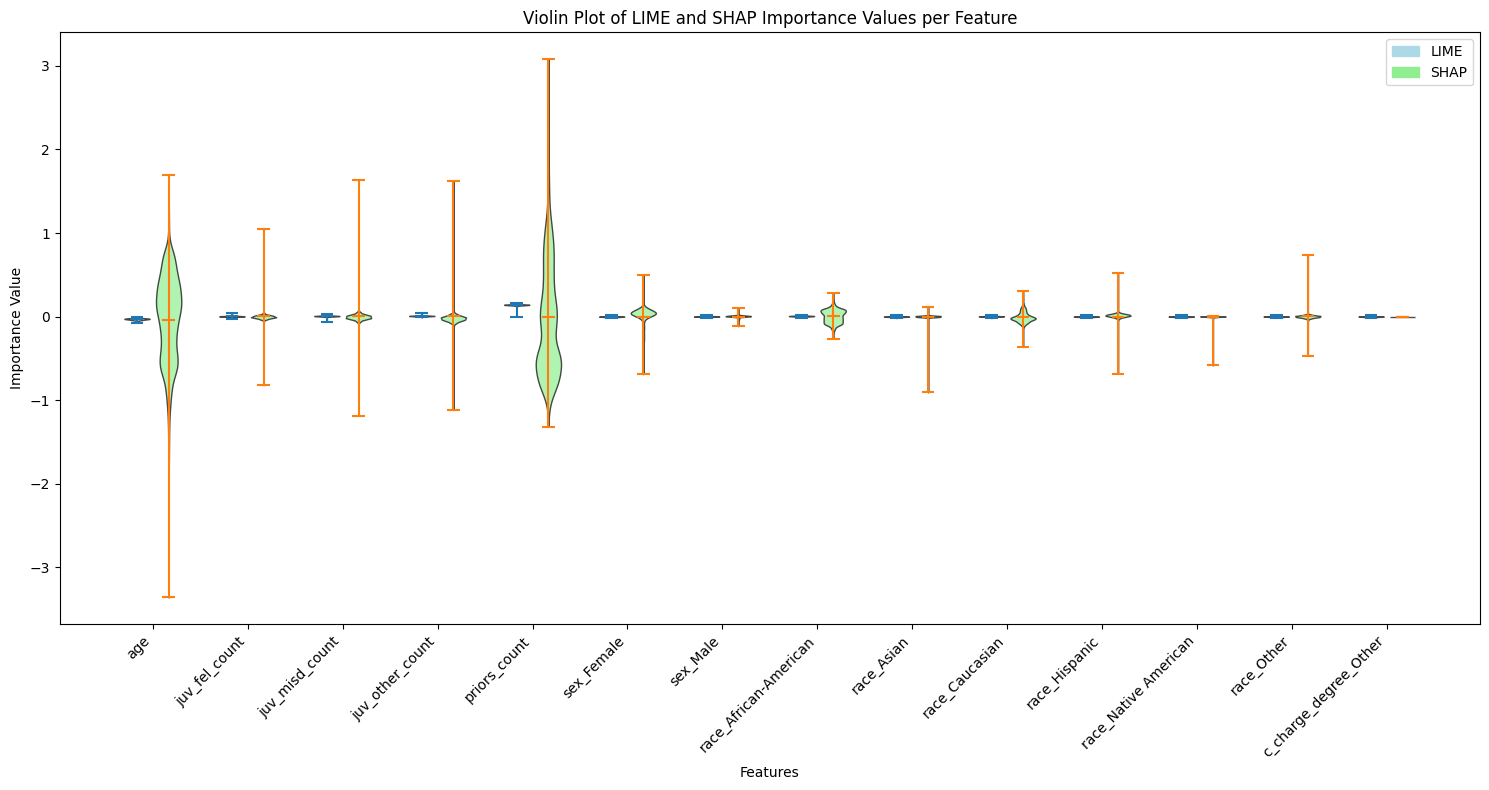

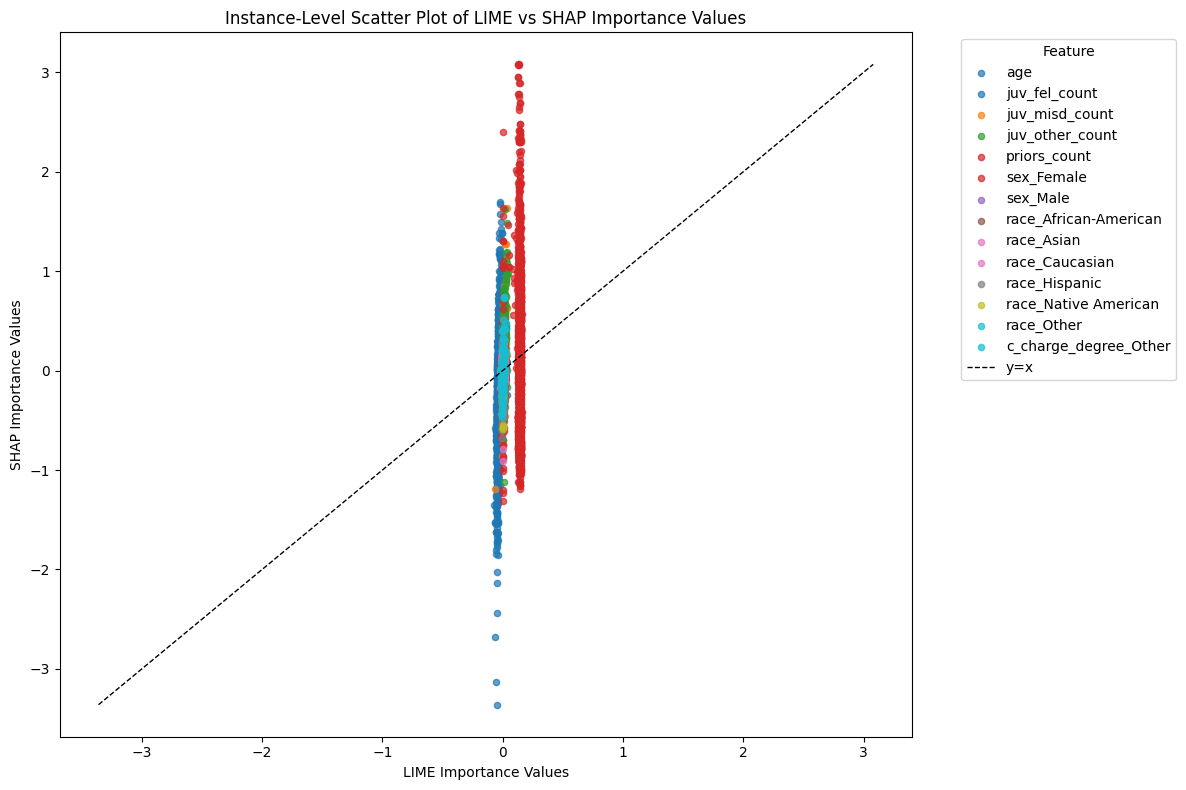

In [4]:
import lime
from lime import lime_tabular
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Wrapper function for XGBoost predict to be compatible with LIME
def predict_proba_xgb(data):
    # Convert to batch prediction format
    if len(data.shape) == 1:
        data = data.reshape(1, -1)
    dmatrix = xgb.DMatrix(data, feature_names=X_train_unscaled.columns.tolist())
    preds = model.predict(dmatrix)
    return np.vstack([1 - preds, preds]).T

# Initialize LIME explainer with optimized settings
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train_unscaled.columns.tolist(),
    class_names=['0', '1'],
    mode='classification',
    random_state=42,
    kernel_width=3,  # Optimized kernel width
    discretize_continuous=False  # Disable discretization for faster processing
)

# Pre-allocate dictionaries for storing weights
lime_weights_dict = {feature: np.zeros(len(X_test)) for feature in X_train_unscaled.columns}

# Process LIME explanations in batches
BATCH_SIZE = 50
for i in range(0, len(X_test), BATCH_SIZE):
    batch = X_test[i:i + BATCH_SIZE]

    # Generate explanations for the batch
    for j, instance in enumerate(batch):
        exp = explainer_lime.explain_instance(
            instance,
            predict_proba_xgb,
            num_features=len(X_train_unscaled.columns),
            num_samples=1000  # Reduced samples for faster processing
        )

        # Process feature weights
        for feat_desc, weight in exp.as_list():
            match = re.match(r'([^<>=]+)', feat_desc)
            feat_name = match.group(1).strip() if match else feat_desc
            if feat_name in lime_weights_dict:
                lime_weights_dict[feat_name][i + j] = weight

# --- SHAP Explanation (Optimized) ---
# Initialize SHAP explainer with optimized settings
explainer_shap = shap.TreeExplainer(model, feature_perturbation='interventional')

# Calculate SHAP values in batches
shap_values = []
for i in range(0, len(X_test), BATCH_SIZE):
    batch = X_test[i:i + BATCH_SIZE]
    shap_values.append(explainer_shap.shap_values(batch))

# Combine batched SHAP values
shap_values = np.concatenate(shap_values)

# Store SHAP values efficiently
shap_values_dict = {
    feature: shap_values[:, idx].tolist()
    for idx, feature in enumerate(X_test_unscaled.columns)
}

# Calculate feature importance statistics
features = list(X_test_unscaled.columns)
lime_means = np.array([np.mean(np.abs(lime_weights_dict[f])) for f in features])
shap_means = np.array([np.mean(np.abs(shap_values_dict[f])) for f in features])

# Plotting
plt.figure(figsize=(12, 6))

# Plot connecting lines more efficiently
x = np.arange(len(features))
for i, (lime_mean, shap_mean) in enumerate(zip(lime_means, shap_means)):
    plt.plot([x[i], x[i]], [lime_mean, shap_mean], color='gray', linestyle='--', linewidth=1)

# Plot scatter points
plt.scatter(x, lime_means, marker='o', s=100, label='LIME', zorder=3)
plt.scatter(x, shap_means, marker='o', s=100, label='SHAP', zorder=3)

plt.xticks(x, features, rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Mean Absolute Importance")
plt.title(f"Comparison of LIME and SHAP Feature Importances (over {len(X_test)} instances)")
plt.legend()
plt.tight_layout()
plt.show()

# Violin plot optimization
features = list(X_test_unscaled.columns)
positions_lime = np.arange(len(features)) * 3 + 1
positions_shap = positions_lime + 1
tick_positions = positions_lime + 0.5

# Prepare data more efficiently
data_lime = [lime_weights_dict[f] for f in features]
data_shap = [shap_values_dict[f] for f in features]

plt.figure(figsize=(15, 8))

# Create violin plots
parts_lime = plt.violinplot(data_lime, positions=positions_lime, widths=0.8, showmeans=True)
parts_shap = plt.violinplot(data_shap, positions=positions_shap, widths=0.8, showmeans=True)

# Style violins
for parts, color in [(parts_lime, 'lightblue'), (parts_shap, 'lightgreen')]:
    for pc in parts['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)

plt.xticks(tick_positions, features, rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance Value")
plt.title("Violin Plot of LIME and SHAP Importance Values per Feature")

# Create legend
import matplotlib.patches as mpatches
lime_patch = mpatches.Patch(color='lightblue', label='LIME')
shap_patch = mpatches.Patch(color='lightgreen', label='SHAP')
plt.legend(handles=[lime_patch, shap_patch])

plt.tight_layout()
plt.show()

# Scatter plot optimization
plt.figure(figsize=(12, 8))

# Use a colormap for distinct colors
colors = plt.cm.tab10(np.linspace(0, 1, len(features)))

# Vectorized scatter plot
for i, (feature, color) in enumerate(zip(features, colors)):
    lime_vals = np.array(lime_weights_dict[feature])
    shap_vals = np.array(shap_values_dict[feature])
    plt.scatter(lime_vals, shap_vals, color=color, alpha=0.7, label=feature, s=20)

# Calculate reference line limits efficiently
all_vals = np.concatenate([
    np.concatenate(list(lime_weights_dict.values())),
    np.concatenate(list(shap_values_dict.values()))
])
min_val, max_val = np.min(all_vals), np.max(all_vals)
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=1, label='y=x')

plt.xlabel("LIME Importance Values")
plt.ylabel("SHAP Importance Values")
plt.title("Instance-Level Scatter Plot of LIME vs SHAP Importance Values")
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()